In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from itertools import combinations 

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


-------------------------
*up bond yield, lower policy and vice versa*

bond yields > asset yields

policy rate + gdp > loans > asset yields

CASA level and policy rates > COF

asset yields + COF > NII

### Data Preprocessing

In [2]:
data = os.path.join('datasets', '9M21_asset_yield_data_combined.csv')

df = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True)

df.head(-1)

,policy,loans_gth,yields,cof,nim,deposit,deposit_gth,gdp_gth,t3m,t5yr,t10yr
2001-01-01,10.00,NaN,NaN,NaN,NaN,NaN,NaN,0.024141,10.205600,13.851750,14.614300
2001-04-01,9.00,NaN,NaN,NaN,NaN,NaN,NaN,0.032682,9.826169,14.411108,15.104600
2001-07-01,9.00,NaN,NaN,NaN,NaN,NaN,NaN,0.031104,9.727862,15.095631,15.604354
2001-10-01,7.75,NaN,NaN,NaN,NaN,NaN,NaN,0.033486,10.012561,15.343682,16.316212
2002-01-01,7.00,NaN,NaN,NaN,NaN,NaN,NaN,0.038765,7.491891,13.036672,14.351875
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,2.25,0.082119,5.046,1.528,3.681,13198.101,0.127777,-0.169813,2.502892,3.245492,3.581215
2020-07-01,2.25,0.027205,4.794,1.279,3.660,13312.188,0.103811,-0.115851,1.337591,2.542379,2.804258
2020-10-01,2.00,-0.007004,4.510,1.047,3.577,13818.681,0.097763,-0.082621,1.178076,2.748985,3.008303
2021-01-01,2.00,-0.042819,4.271,0.878,3.493,13946.624,0.082426,-0.038984,1.080953,2.909859,3.561234


In [3]:
gdp_gth = df.gdp_gth.dropna() #
loans_gth = df.loans_gth.dropna() #
deposit = df.deposit_gth.dropna()
policy = df.policy.dropna()#
asset_yld = df.yields.dropna() #
cof = df.cof.dropna() #
nim = df.nim.dropna() #
t10yr = df.t10yr.dropna()
t5yr = df.t5yr.dropna() #
t91day = df.t3m.dropna() #


series_asset_yld1 = [asset_yld, gdp_gth, policy]
series_asset_yld2 = [asset_yld, t10yr, t91day, t5yr]
series_cof = [cof, deposit, policy]
series_nim = [nim, asset_yld, cof]
series_loan = [loans_gth, gdp_gth, policy]


C:\Users\Derrick\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


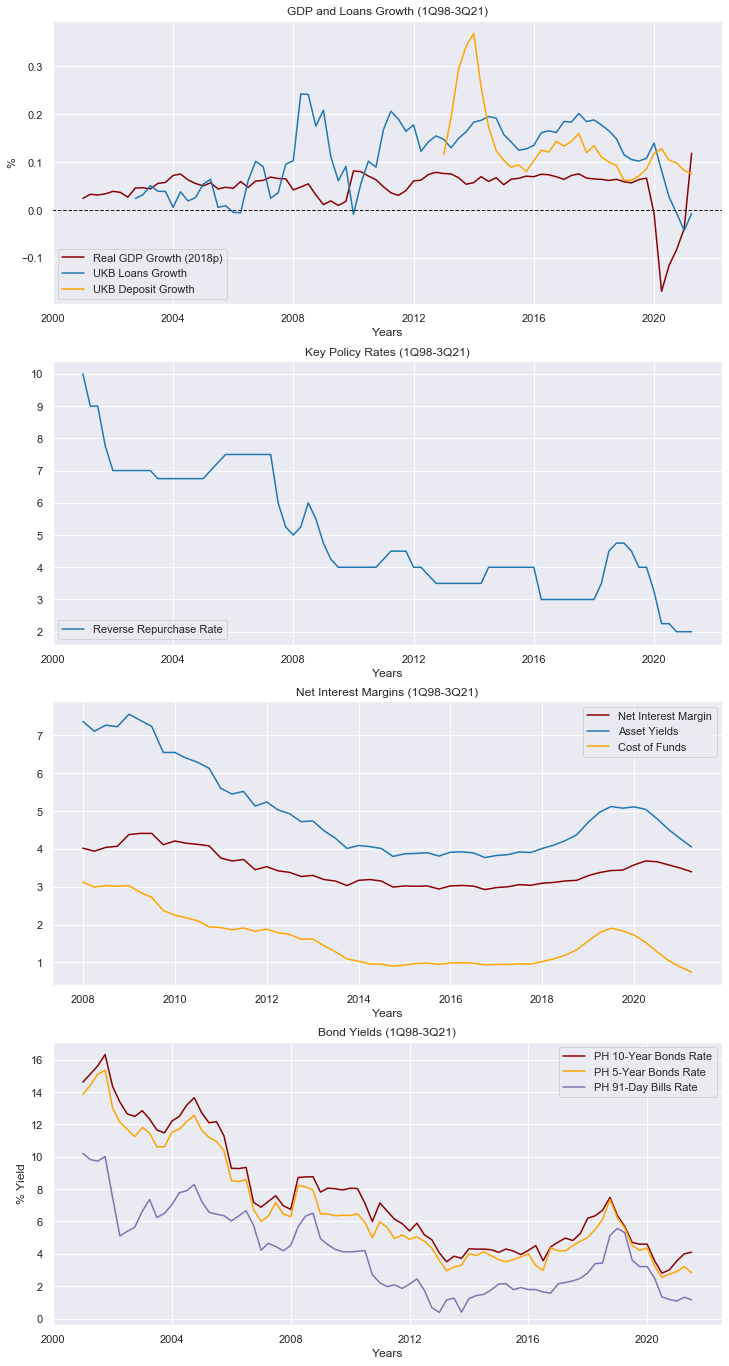

In [4]:
# plotting
def plots():

    sns.set(style="darkgrid")

    fig = plt.figure(figsize=(12,24))
    #fig = plt.figure(figsize=(12,12))

    plt.subplot(4, 1, 1)
    plt.plot(gdp_gth, color='darkred', label='Real GDP Growth (2018p)')
    plt.plot(loans_gth, color='tab:blue', label='UKB Loans Growth')
    plt.plot(deposit, color='orange', label='UKB Deposit Growth')
    plt.title('GDP and Loans Growth (1Q98-3Q21)')
    plt.legend(loc=3)
    plt.xlabel('Years')
    plt.ylabel('%')
    plt.axhline(linewidth=1, linestyle='dashed', color='k')

    plt.subplot(4, 1, 2)
    plt.plot(policy, color='tab:blue', label='Reverse Repurchase Rate')
    plt.title('Key Policy Rates (1Q98-3Q21)')
    plt.legend(loc=3)
    plt.xlabel('Years')
    #plt.ylabel('Y-o-Y Growth')

    plt.subplot(4, 1, 3)
    plt.plot(nim, color='darkred', label='Net Interest Margin')
    plt.plot(asset_yld, color='tab:blue', label='Asset Yields')
    plt.plot(cof, color='orange', label='Cost of Funds')
    plt.title('Net Interest Margins (1Q98-3Q21)')
    plt.legend()
    plt.xlabel('Years')
    #plt.ylabel('index')

    plt.subplot(4, 1, 4)
    plt.plot(t10yr.bfill(), color='darkred', label='PH 10-Year Bonds Rate')
    plt.plot(t5yr.bfill(), color='orange', label='PH 5-Year Bonds Rate')
    plt.plot(t91day.bfill(), color='m', label='PH 91-Day Bills Rate')
    plt.title('Bond Yields (1Q98-3Q21)')
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel('% Yield')

    plt.show()

plots()

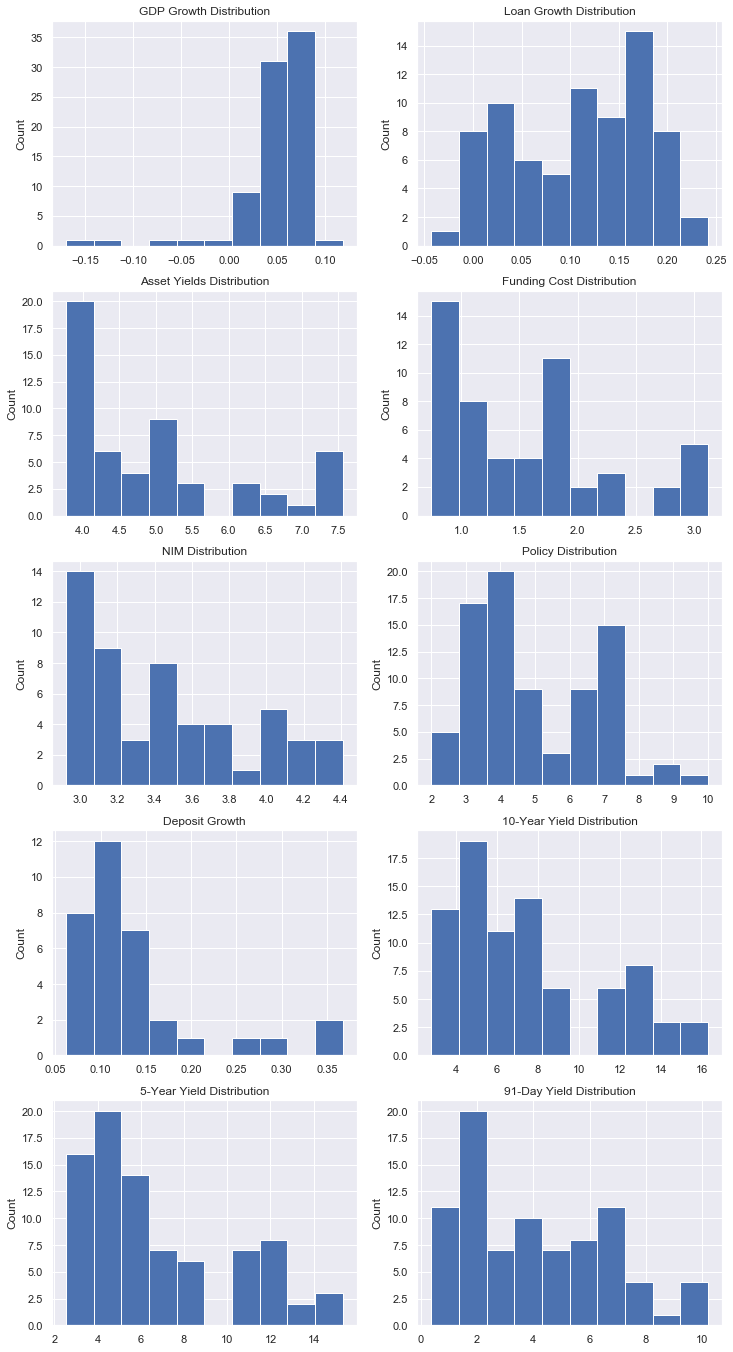

In [5]:
# checking for normality by plotting

def all_dist():
    fig = plt.figure(figsize=(12,24))

    plt.subplot(5,2,1)
    plt.hist(gdp_gth)
    plt.title('GDP Growth Distribution')
    plt.ylabel('Count')

    plt.subplot(5,2,2)
    plt.hist(loans_gth)
    plt.title('Loan Growth Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 3)
    plt.hist(asset_yld)
    plt.title('Asset Yields Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 4)
    plt.hist(cof)
    plt.title('Funding Cost Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 5)
    plt.hist(nim)
    plt.title('NIM Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 6)
    plt.hist(policy)
    plt.title('Policy Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 7)
    plt.hist(deposit)
    plt.title('Deposit Growth')
    plt.ylabel('Count')
    
    plt.subplot(5, 2, 8)
    plt.hist(t10yr)
    plt.title('10-Year Yield Distribution')
    plt.ylabel('Count')
    
    plt.subplot(5, 2, 9)
    plt.hist(t5yr)
    plt.title('5-Year Yield Distribution')
    plt.ylabel('Count')
    
    plt.subplot(5, 2, 10)
    plt.hist(t91day)
    plt.title('91-Day Yield Distribution')
    plt.ylabel('Count')

    plt.show()
    
all_dist()

### Test for Stationarity

In [6]:
#testing for stationarity

def adf_test(series, name=None, num=None):
    result = adfuller(series)
    if name == None:
        name = str(series.name)
    if num != None:
        name = 'Series %s' % str(num)
    print('\n%s:' %name)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# 
series = [loans_gth, gdp_gth, deposit, asset_yld, cof, nim, policy, t10yr, t5yr, t91day]
    
for s in series:
    adf_test(s)


loans_gth:
ADF Statistic: -1.788512
p-value: 0.386180

gdp_gth:
ADF Statistic: -6.463577
p-value: 0.000000

deposit_gth:
ADF Statistic: -0.968420
p-value: 0.764608

yields:
ADF Statistic: -1.330297
p-value: 0.615200

cof:
ADF Statistic: -2.435273
p-value: 0.132027

nim:
ADF Statistic: -1.338827
p-value: 0.611227

policy:
ADF Statistic: -1.658108
p-value: 0.452815

t10yr:
ADF Statistic: -2.284305
p-value: 0.177080

t5yr:
ADF Statistic: -1.733958
p-value: 0.413707

t3m:
ADF Statistic: -2.394417
p-value: 0.143318


### Transformation
- Normalization,
- Differencing,
- Treating unequal variance,
- Adjusting for seasonality



#### Making Stationary

In [9]:
def normalize(series):
    ave, stdev = series.mean(), series.std()
    series = (series-ave)/stdev
    return series

def annual_vol(series):
    stdevs = series.groupby(series.index.year).std()
    return series.index.map(lambda d: stdevs.loc[d.year])

def variance_correct(series):
    return series/annual_vol(series)

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

def make_stationary(*data, plot=False, headers=True):
    stdata = []
    for d in data:
        if headers == True:
            header = d.name
        d = normalize(d)
        d = d.diff().dropna()
        d = variance_correct(d).dropna()
        #d = seasonality_correct(d).dropna()
        d.name = header
        stdata.append(d)
        
    if len(stdata) == 1:
        return stdata[0]
    else:
        return stdata



In [10]:

series = make_stationary(loans_gth, gdp_gth, deposit, asset_yld, cof, nim, policy, t10yr, t5yr, t91day)

for s in series:
    adf_test(s)


loans_gth:
ADF Statistic: -5.114428
p-value: 0.000013

gdp_gth:
ADF Statistic: -5.010145
p-value: 0.000021

deposit_gth:
ADF Statistic: -4.994871
p-value: 0.000023

yields:
ADF Statistic: -3.064569
p-value: 0.029289

cof:
ADF Statistic: -2.504428
p-value: 0.114401

nim:
ADF Statistic: -2.345573
p-value: 0.157690

policy:
ADF Statistic: -5.635541
p-value: 0.000001

t10yr:
ADF Statistic: -6.834820
p-value: 0.000000

t5yr:
ADF Statistic: -7.008089
p-value: 0.000000

t3m:
ADF Statistic: -4.493894
p-value: 0.000202


In [18]:
loans_gth = make_stationary(loans_gth)
gdp_gth = make_stationary(gdp_gth)
asset_yld = make_stationary(asset_yld)
cof = make_stationary(cof)
nim = make_stationary(nim)
policy = make_stationary(policy)
deposit = make_stationary(deposit)
t10yr = make_stationary(t10yr)
t5yr = make_stationary(t5yr)
t91day = make_stationary(t91day)

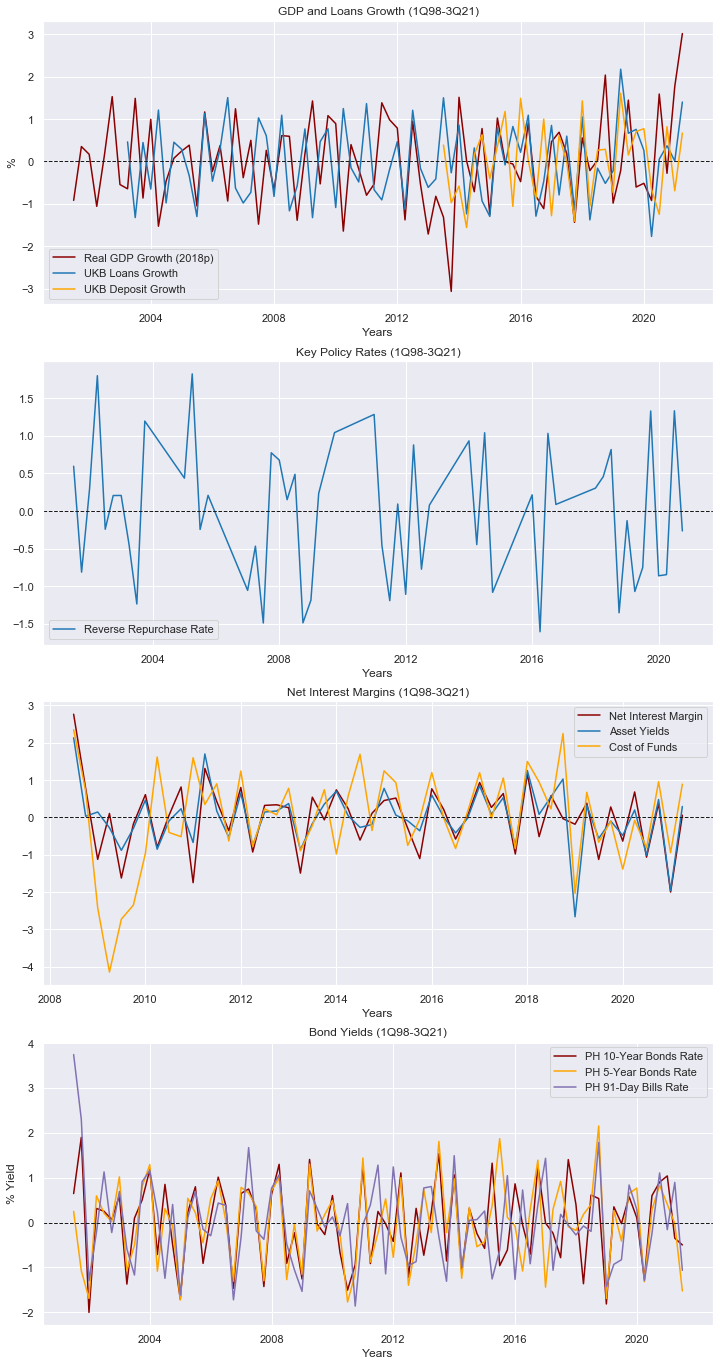

In [21]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(12,24))

plt.subplot(4, 1, 1)
plt.plot(gdp_gth, color='darkred', label='Real GDP Growth (2018p)')
plt.plot(loans_gth, color='tab:blue', label='UKB Loans Growth')
plt.plot(deposit, color='orange', label='UKB Deposit Growth')
plt.title('GDP and Loans Growth (1Q98-3Q21)')
plt.legend(loc=3)
plt.xlabel('Years')
plt.ylabel('%')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.subplot(4, 1, 2)
plt.plot(policy, color='tab:blue', label='Reverse Repurchase Rate')
plt.title('Key Policy Rates (1Q98-3Q21)')
plt.legend(loc=3)
plt.xlabel('Years')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.subplot(4, 1, 3)
plt.plot(nim, color='darkred', label='Net Interest Margin')
plt.plot(asset_yld, color='tab:blue', label='Asset Yields')
plt.plot(cof, color='orange', label='Cost of Funds')
plt.title('Net Interest Margins (1Q98-3Q21)')
plt.legend()
plt.xlabel('Years')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.subplot(4, 1, 4)
plt.plot(t10yr.bfill(), color='darkred', label='PH 10-Year Bonds Rate')
plt.plot(t5yr.bfill(), color='orange', label='PH 5-Year Bonds Rate')
plt.plot(t91day.bfill(), color='m', label='PH 91-Day Bills Rate')
plt.title('Bond Yields (1Q98-3Q21)')
plt.legend()
plt.xlabel('Years')
plt.ylabel('% Yield')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.show()


### Running Granger Causality on Corrected Data

In [29]:
def granger(s1, s2, lag=6):
    granger_df = pd.concat([s1, s2], axis=1).dropna()
    grangercausalitytests(granger_df, lag)
    
comb = [[loans_gth, gdp_gth], #1
       [loans_gth, policy], #2
       [nim, cof], #3
       [nim, asset_yld], #4
       [cof, policy], #5
       [cof, deposit], #6
       [nim, policy], #7
       [asset_yld, gdp_gth],#8
       [asset_yld, policy], #9
       [asset_yld, t10yr], #10
       [asset_yld, t5yr], #11
       [asset_yld, t91day], #12
       [nim, t10yr], #13
       [nim, t5yr], #14
       [nim, t91day]] #15

comb[0][0].name

'loans_gth'

In [30]:
#try on every combination
num = 0
for c in comb:
    num += 1
    print('Granger Causality Results for Relation %s' %str(num))
    print('-------------------------------------------------')
    print('\nBetween %s' %str(c[0].name)+' and '+str(c[1].name))
    print('\n%s as Affected: ' %str(c[0].name))
    granger(c[0], c[1], lag=4)
    print('\n%s as Affected: ' %str(c[1].name))
    granger(c[1], c[0], lag=4)
    print('\n=================================================\n')

Granger Causality Results for Relation 1
-------------------------------------------------

Between loans_gth and gdp_gth

loans_gth as Affected: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0810  , p=0.1537  , df_denom=69, df_num=1
ssr based chi2 test:   chi2=2.1715  , p=0.1406  , df=1
likelihood ratio test: chi2=2.1394  , p=0.1436  , df=1
parameter F test:         F=2.0810  , p=0.1537  , df_denom=69, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8142  , p=0.1710  , df_denom=66, df_num=2
ssr based chi2 test:   chi2=3.9032  , p=0.1420  , df=2
likelihood ratio test: chi2=3.7997  , p=0.1496  , df=2
parameter F test:         F=1.8142  , p=0.1710  , df_denom=66, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2890  , p=0.2859  , df_denom=63, df_num=3
ssr based chi2 test:   chi2=4.2967  , p=0.2312  , df=3
likelihood ratio test: chi2=4.1700  , p=0.2437  , df=3
parameter F test:        

parameter F test:         F=0.6986  , p=0.5582  , df_denom=42, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9785  , p=0.4304  , df_denom=39, df_num=4
ssr based chi2 test:   chi2=4.8170  , p=0.3066  , df=4
likelihood ratio test: chi2=4.5904  , p=0.3320  , df=4
parameter F test:         F=0.9785  , p=0.4304  , df_denom=39, df_num=4

yields as Affected: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8101  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=0.0620  , p=0.8033  , df=1
likelihood ratio test: chi2=0.0620  , p=0.8034  , df=1
parameter F test:         F=0.0584  , p=0.8101  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2137  , p=0.8084  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=0.4749  , p=0.7886  , df=2
likelihood ratio test: chi2=0.4726  , p=0.7895  , df=2
parameter F test:         F=0.2137  , p=0.8084  , df_denom=45, df_num=2

Grang

parameter F test:         F=2.3948  , p=0.0669  , df_denom=39, df_num=4

gdp_gth as Affected: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3227  , p=0.5726  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=0.3429  , p=0.5582  , df=1
likelihood ratio test: chi2=0.3417  , p=0.5588  , df=1
parameter F test:         F=0.3227  , p=0.5726  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0805  , p=0.9228  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=0.1789  , p=0.9144  , df=2
likelihood ratio test: chi2=0.1786  , p=0.9146  , df=2
parameter F test:         F=0.0805  , p=0.9228  , df_denom=45, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0787  , p=0.9712  , df_denom=42, df_num=3
ssr based chi2 test:   chi2=0.2756  , p=0.9646  , df=3
likelihood ratio test: chi2=0.2748  , p=0.9647  , df=3
parameter F test:         F=0.0787  , p=0.9712  , df_denom=42, df_num=3

Gran

parameter F test:         F=0.0562  , p=0.9454  , df_denom=45, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2211  , p=0.8812  , df_denom=42, df_num=3
ssr based chi2 test:   chi2=0.7739  , p=0.8557  , df=3
likelihood ratio test: chi2=0.7678  , p=0.8571  , df=3
parameter F test:         F=0.2211  , p=0.8812  , df_denom=42, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4053  , p=0.8037  , df_denom=39, df_num=4
ssr based chi2 test:   chi2=1.9953  , p=0.7366  , df=4
likelihood ratio test: chi2=1.9549  , p=0.7441  , df=4
parameter F test:         F=0.4053  , p=0.8037  , df_denom=39, df_num=4


Granger Causality Results for Relation 13
-------------------------------------------------

Between nim and t10yr

nim as Affected: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0573  , p=0.8118  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=0.0609  , p=0.8051  , df=1
likelihood ratio te

### Model Fitting


NIM:


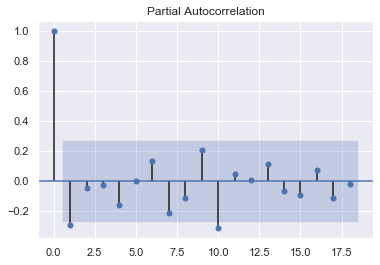

Policy:


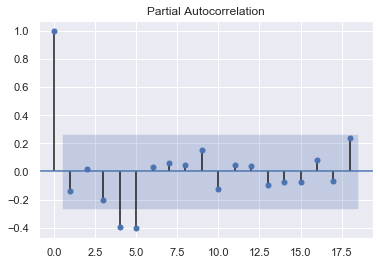

PH 10YR:


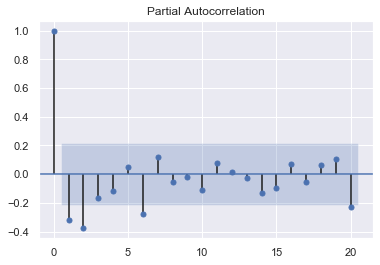

PH 5YR:


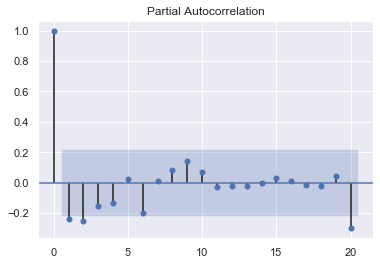

PH 91D:


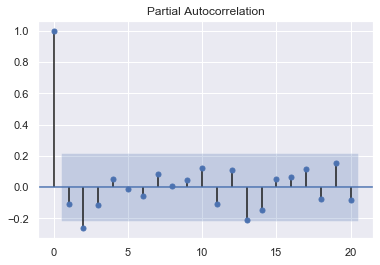

In [28]:
# Plotting partial autocorrelation
series = [nim, policy, t10yr, t5yr, t91day]
s_names = ['NIM', 'Policy', 'PH 10YR', 'PH 5YR', 'PH 91D']

ind = 0
for s in series:
    print('%s:'%s_names[ind])
    plot_pacf(s)
    ind += 1
    plt.show()

#### Fitting and selecting best model

In [21]:
## Automate

def fit_tsmodel(data, model='VAR', lags=4):
    models = ['VAR','SARIMAX']

    if model in models:
        if model == models[0]:
            model = VAR
        elif model == models[1]:
            model == SARIMAX
    else:
        print('Model not supported')
        return None
    
    fmodel = model(data)          
    res = fmodel.fit(maxlags=lags)
    return res

def create_df(*series):
    df = pd.concat(series, axis=1).bfill().dropna()
    n = []
    for i in series:
        n.append(i.name)
    df.columns = n
    return df

In [22]:
# loop through combos
# to check how many possible equations exist
series = [policy, t10yr, t5yr, t91day]
depvar = [asset_yld]
c_list = []
MAX_COMB = 5

# put constraints function where loans/loans grwoth as first item in list
for i in range(1, MAX_COMB):
    l = list(combinations(series, i))
    print('No. of series of combination: %s' %len(l))
    c_list.extend(l)

print('Total no. of combinations: %s \n' %len(c_list))
#print(c_list)


No. of series of combination: 4
No. of series of combination: 6
No. of series of combination: 4
No. of series of combination: 1
Total no. of combinations: 15 



In [23]:
df1 = create_df(nim, policy, t10yr, t5yr, t91day)
df1 = df1.loc['2008-01-01':]

In [24]:
res1 = fit_tsmodel(df1,lags=3)
res1.summary()

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Oct, 2021
Time:                     10:02:50
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                  -0.849498
Nobs:                     152.000    HQIC:                  -1.79448
Log likelihood:          -812.876    FPE:                  0.0874140
AIC:                     -2.44101    Det(Omega_mle):       0.0529971
--------------------------------------------------------------------
Results for equation nim_ukb
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.031989         0.055874            0.573           0.567
L1.nim_ukb         0.846925         0.086680            9.771           0.000
L1.policy          0.078896         0.056453            1.398         


--------------------------
*Some notes*

loan gth -> policy (3Q lag)  
cof -> nim (2-4Q lag) yields no relation  
policy -> cof (1-3Q) (and vice versa)  
deposit growth -> cof (2-4Q lag)  
nim -> policy at lag 1 (interesting, no the other way around)  
gdp gth -> yields (at all lags if 10% sinigicance)  
policy -> yields (1-3Q lags)  
PH3m bond -> yields (1Q lag)  
bonds do not granger cause NIMs  
  

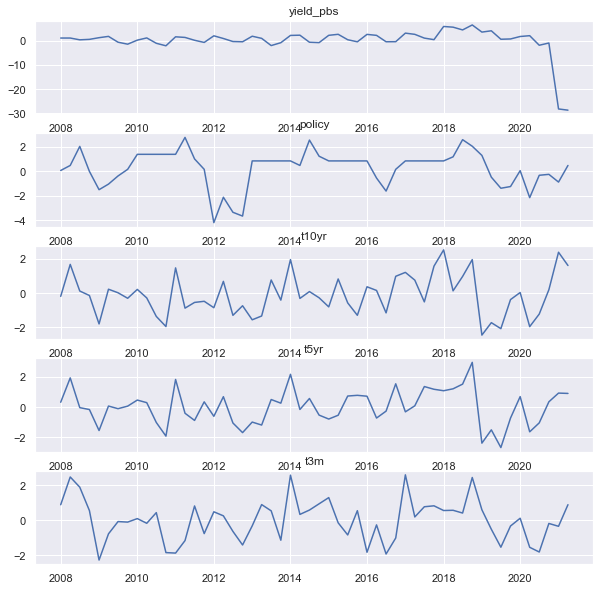

<Figure size 1296x1728 with 0 Axes>

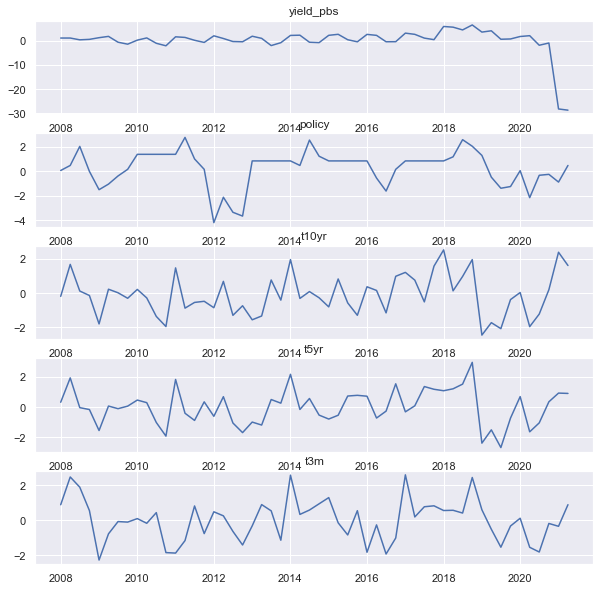

In [115]:
fig = plt.figure(figsize=(18,24))

res1.plot()

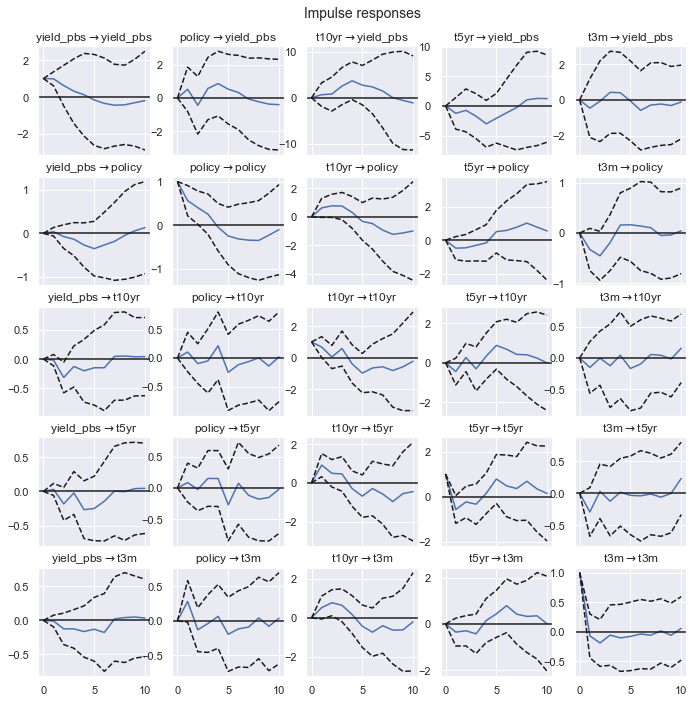

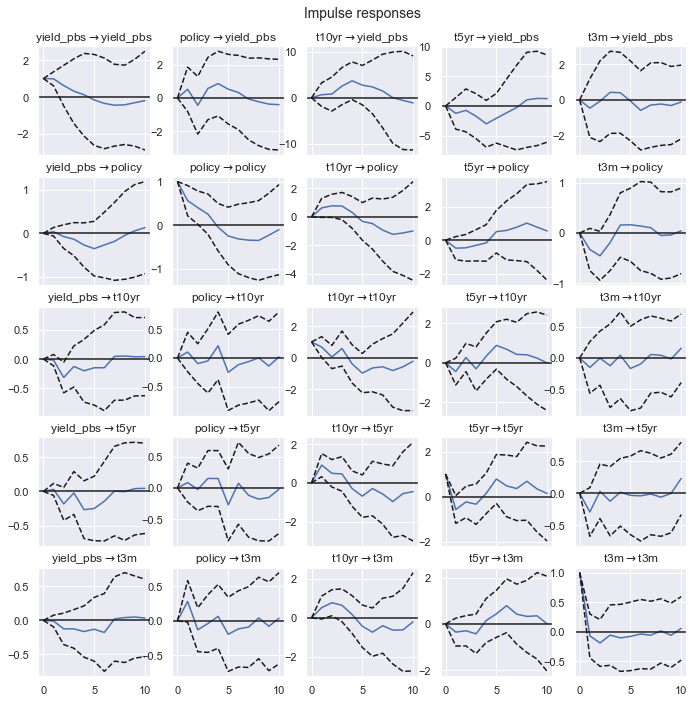

In [116]:
irf = res1.irf(10)
irf.plot(orth=False)

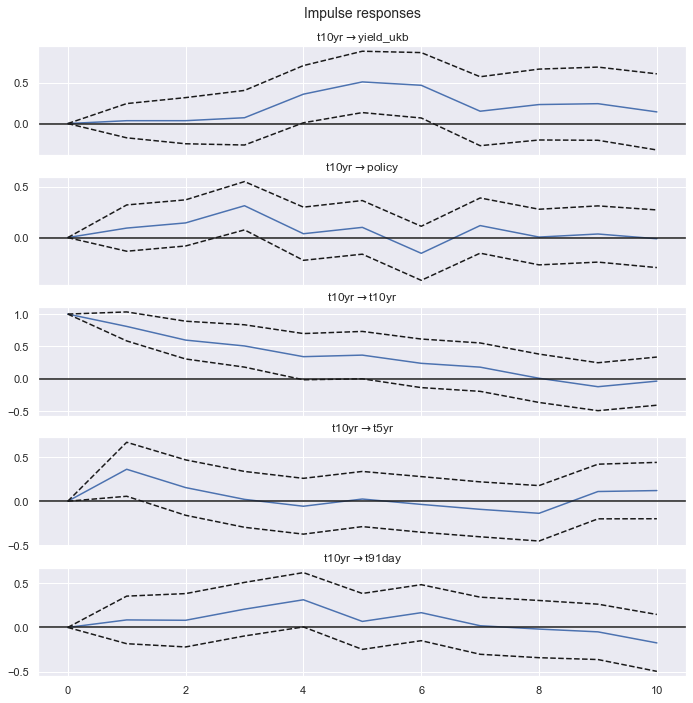

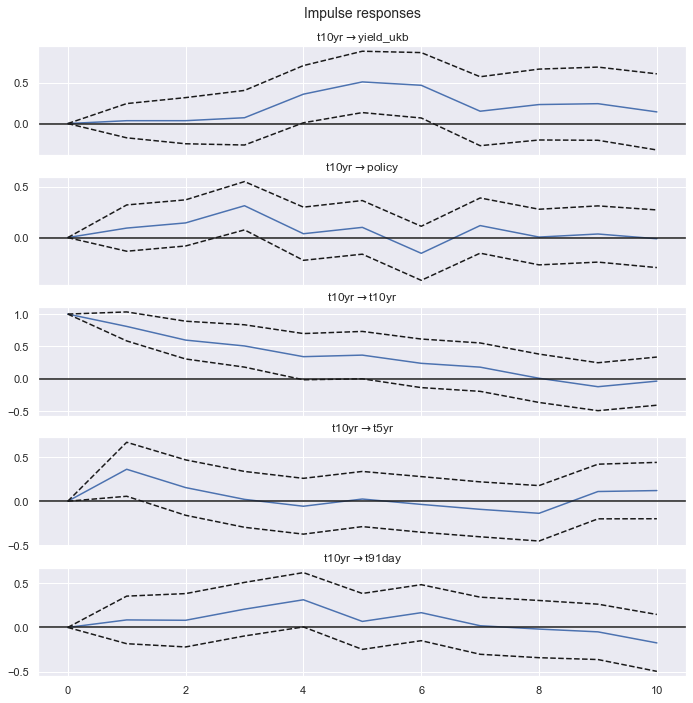

In [71]:
irf.plot(impulse='t10yr')

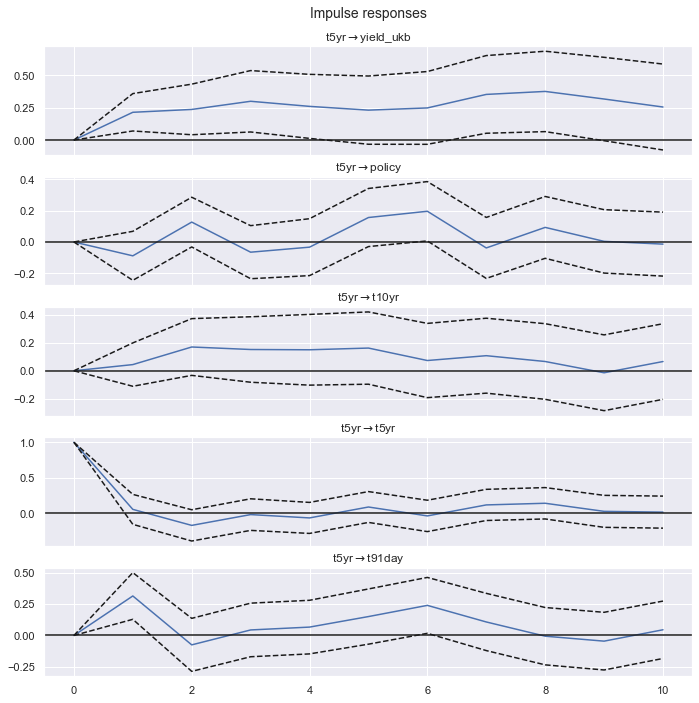

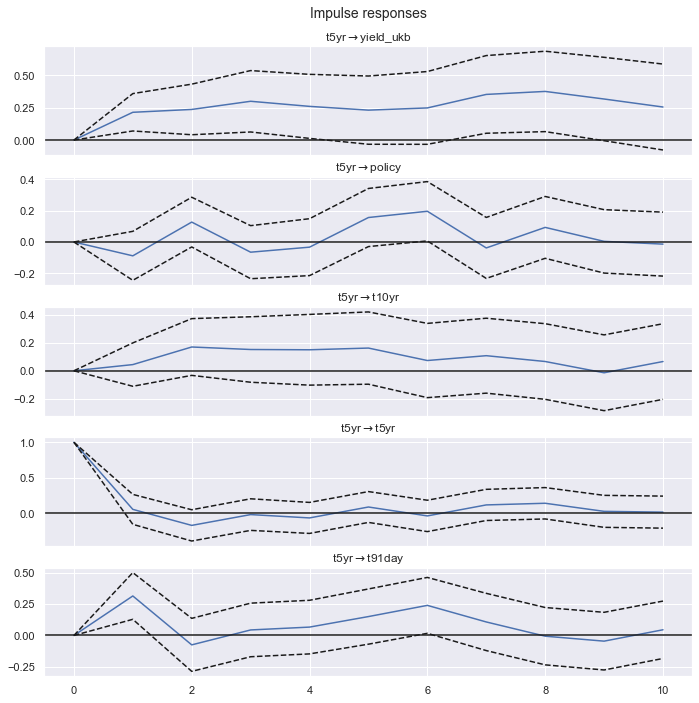

In [72]:
irf.plot(impulse='t5yr')

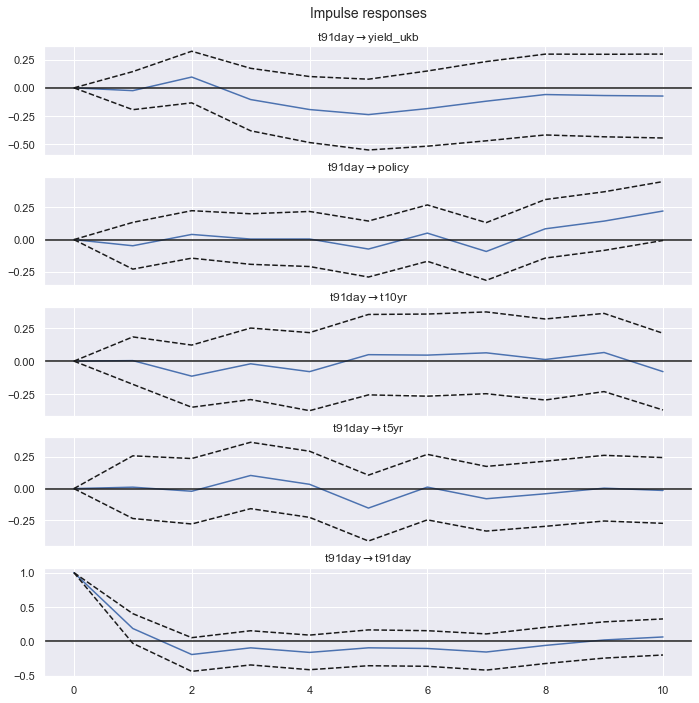

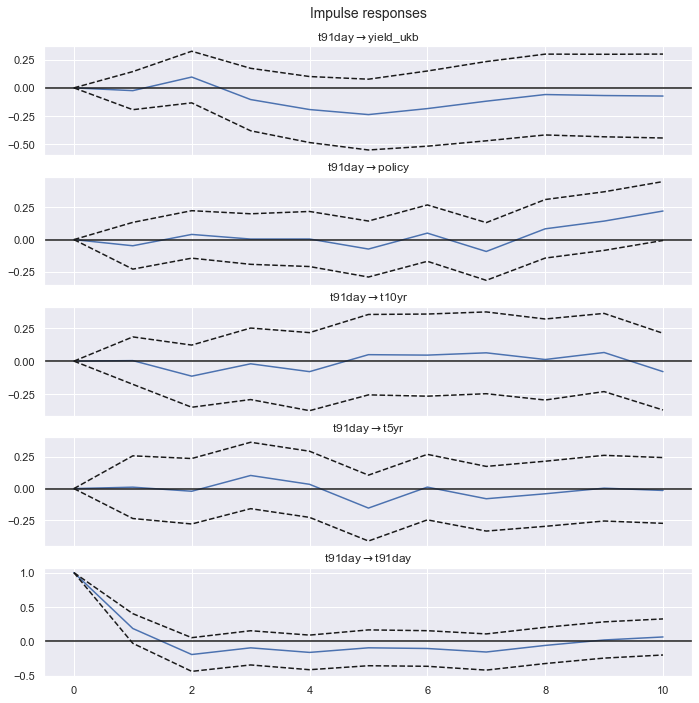

In [73]:
irf.plot(impulse='t91day')

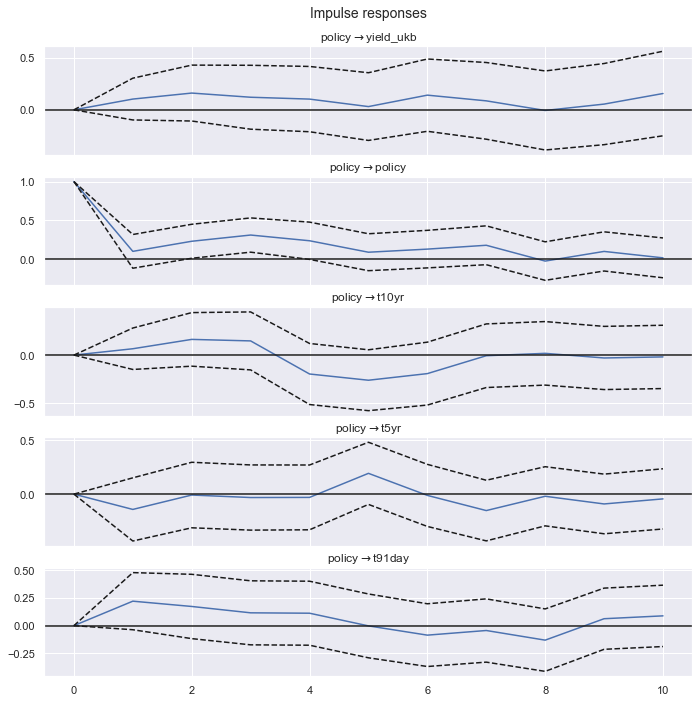

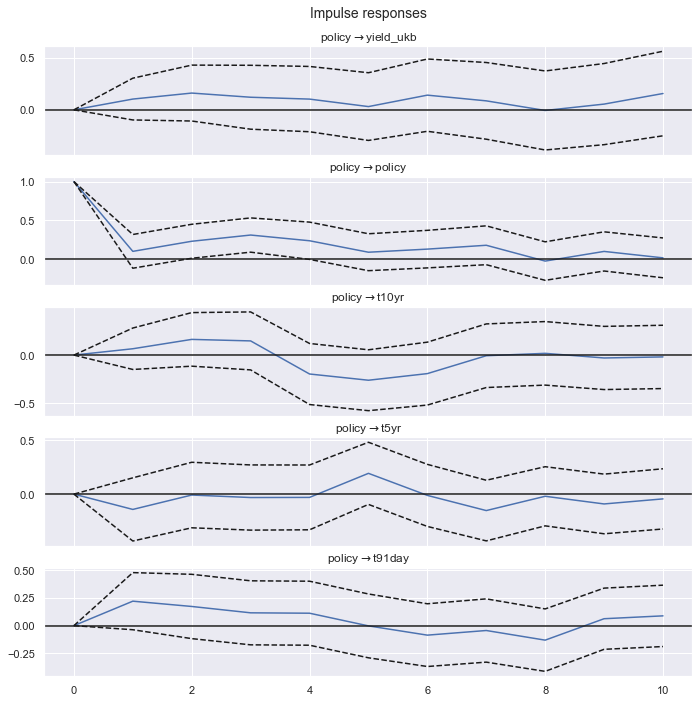

In [74]:
irf.plot(impulse='policy')